In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
from tqdm import tqdm
import seaborn as sns
import matplotlib as mpl
import archetypes as arch
import matplotlib.pyplot as plt
from scipy.stats import entropy
from scipy.stats import pearsonr
import sklearn.metrics as metrics
from scipy.spatial.distance import jensenshannon
from scipy.cluster.hierarchy import linkage, leaves_list
from scipy import sparse
import math
import anndata
from scipy.sparse import csr_matrix

In [2]:
import os
import sys
module_path = os.path.abspath('/mnt/c/Users/demeter_turos/PycharmProjects/chrysalis')
if module_path not in sys.path:
    sys.path.append(module_path)

import chrysalis as ch

data_path = '/mnt/c/Users/demeter_turos/PycharmProjects/chrysalis/data/slide_seq/'

In [ ]:
adata = sc.read_text(data_path + 'Puck_200115_08.digital_expression.txt.gz')

adata.X = adata.X.astype(int)
sparse_X = sparse.csr_matrix(adata.X)
adata.X = sparse_X
adata = adata.T

locations = pd.read_csv(data_path + 'Puck_200115_08_bead_locations.csv', sep=',', index_col=0)
adata.obsm['spatial'] = np.array(locations)
adata.write(data_path + 'puck_200115_08.h5ad')

In [5]:
def bin_adata(adata, bins=50):

    xmin = float(np.min(adata.obsm['spatial'][:, 0]))
    xmax = float(np.max(adata.obsm['spatial'][:, 0]))
    x_dist = float(np.diff([xmin, xmax]))

    ymin = float(np.min(adata.obsm['spatial'][:, 1]))
    ymax = float(np.max(adata.obsm['spatial'][:, 1]))
    y_dist = float(np.diff([ymin, ymax]))

    xbins = np.linspace(xmin, xmax, bins + 1)
    ybins = np.linspace(ymin, ymax, bins + 1)

    counts = np.zeros((bins ** 2, adata.shape[1])).astype(int)
    xpos = []
    ypos = []
    n_cells = []

    i = 0
    for x in tqdm(range(len(xbins) - 1)):
        xlower = xbins[x]
        xupper = xbins[x + 1]

        xcells = (adata.obsm['spatial'][:, 0] >= xlower) & (xupper > adata.obsm['spatial'][:, 0])

        x_mean = np.average((xlower, xupper))

        for y in range(len(ybins) - 1):
            ylower = ybins[y]
            yupper = ybins[y + 1]

            ycells = (adata.obsm['spatial'][:, 1] >= ylower) & (yupper > adata.obsm['spatial'][:, 1])
            subset = adata[xcells * ycells, :]
            subset_df = subset.to_df()

            counts[i, :] = subset_df.sum(axis=0).values.astype(int)

            y_mean = np.average((ylower, yupper))

            xpos.append(x_mean)
            ypos.append(y_mean)
            n_cells.append(len(subset_df))

            i += 1

    xy_pos = np.array((xpos, ypos)).T
    binned_adata = anndata.AnnData(X=csr_matrix(counts),
                                   obs=pd.DataFrame(index=[*range(len(counts))]),
                                   var=pd.DataFrame(index=adata.var_names),
                                   )
    binned_adata.obsm['spatial'] = xy_pos
    binned_adata.obs['cells_in_bin'] = n_cells
    return binned_adata

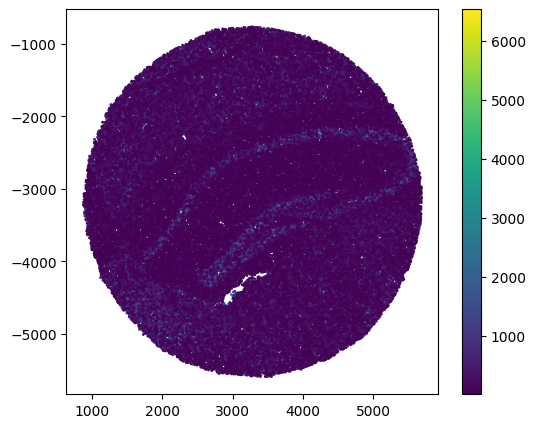

In [7]:
adata = sc.read_h5ad(data_path + 'puck_200115_08.h5ad')

sc.pp.calculate_qc_metrics(adata, inplace=True)

# there are some outlier spots outside of the capture area (?)
x_cent = np.mean(adata.obsm['spatial'][:, 0])
y_cent = np.mean(adata.obsm['spatial'][:, 1])

adata.obs['euc_distance'] = [math.dist([x[0], x[1]], [x_cent, y_cent]) for x in adata.obsm['spatial']]
adata = adata[adata.obs['euc_distance'] < 2440]

fig, ax = plt.subplots(1, 1, figsize=(6, 5))
plt.scatter(adata.obsm['spatial'][:, 0], adata.obsm['spatial'][:, 1] * -1, s=1, c=adata.obs['n_genes_by_counts'])
plt.colorbar()
plt.show()

100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:23<00:00,  4.29it/s]


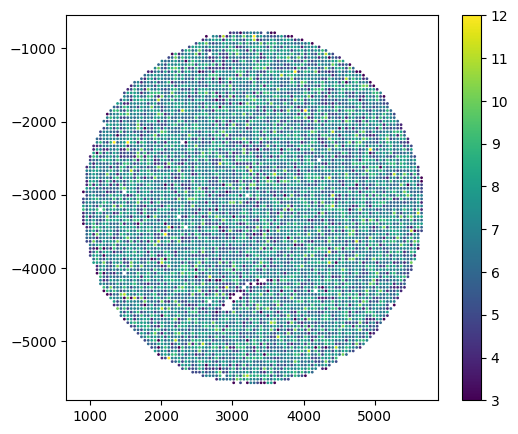

In [9]:
binned_adata = bin_adata(adata, bins=100)

binned_adata = binned_adata[binned_adata.obs['cells_in_bin'] > 2]

fig, ax = plt.subplots(1, 1, figsize=(6, 5))
plt.scatter(binned_adata.obsm['spatial'][:, 0],
            binned_adata.obsm['spatial'][:, 1] * -1, s=1,
            c=binned_adata.obs['cells_in_bin'])
plt.colorbar()
plt.show()

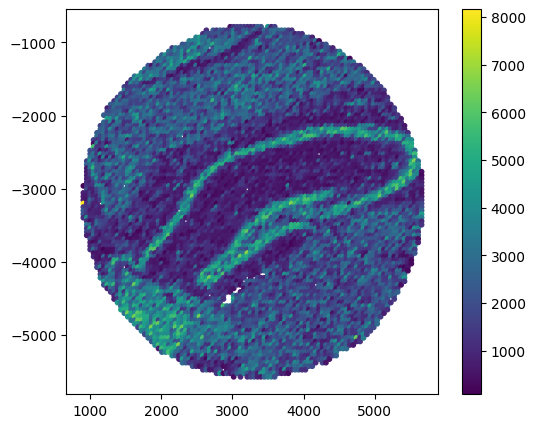

In [10]:
sc.pp.calculate_qc_metrics(binned_adata, inplace=True)
sc.pp.filter_cells(binned_adata, min_counts=100)
sc.pp.filter_genes(binned_adata, min_cells=10)

fig, ax = plt.subplots(1, 1, figsize=(6, 5))
plt.scatter(binned_adata.obsm['spatial'][:, 0],
            binned_adata.obsm['spatial'][:, 1] * -1, s=10,
            c=binned_adata.obs['n_genes_by_counts'])
plt.colorbar()
plt.show()

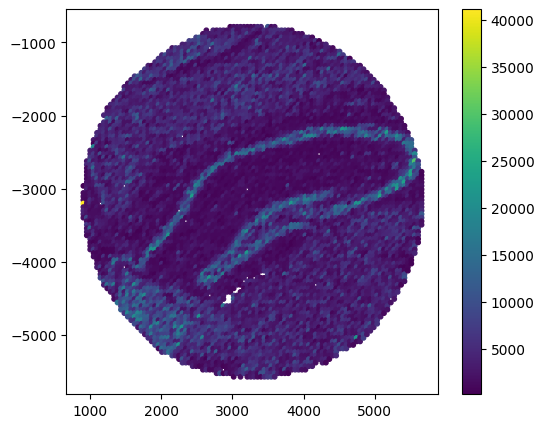

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
plt.scatter(binned_adata.obsm['spatial'][:, 0],
            binned_adata.obsm['spatial'][:, 1] * -1, s=10,
            c=binned_adata.obs['total_counts'])
plt.colorbar()
plt.show()

In [ ]:
chr.detect_svgs(binned_adata, min_morans=0.05, min_spots=0.05, top_svg=1000, neighbors=8)

binned_adata.write(data_path + 'chr_bin_100.h5ad')

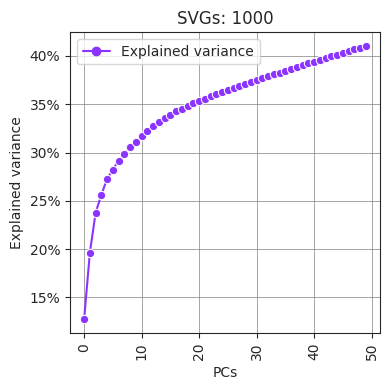

In [12]:
binned_adata = sc.read_h5ad(data_path + 'chr_bin_100.h5ad')

sc.pp.normalize_total(binned_adata, inplace=True)
sc.pp.log1p(binned_adata)

ch.pca(binned_adata, n_pcs=50)

ch.plot_explained_variance(binned_adata)
plt.show()

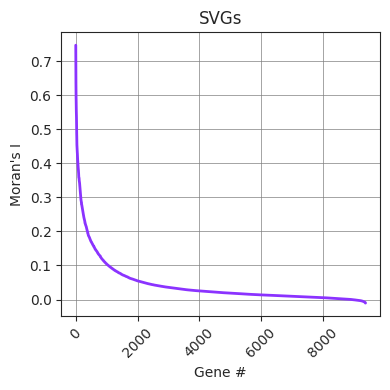

In [13]:
ch.plot_svgs(binned_adata)
plt.show()

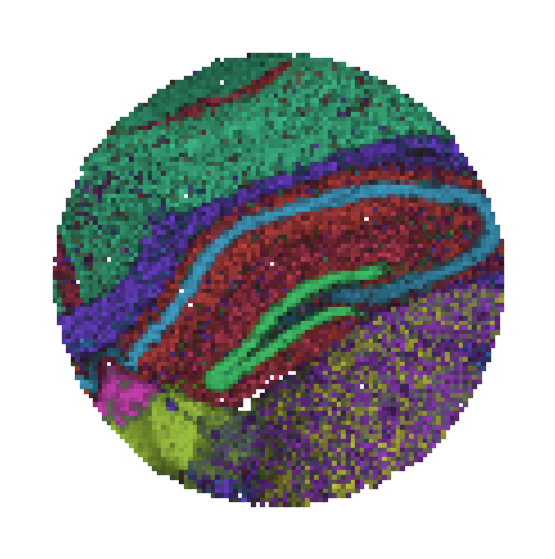

In [14]:
ch.aa(binned_adata, n_pcs=20, n_archetypes=11)
ch.plot(binned_adata, dim=11, spot_size=0.7, marker='s', seed=4, figsize=(7, 7))
plt.show()

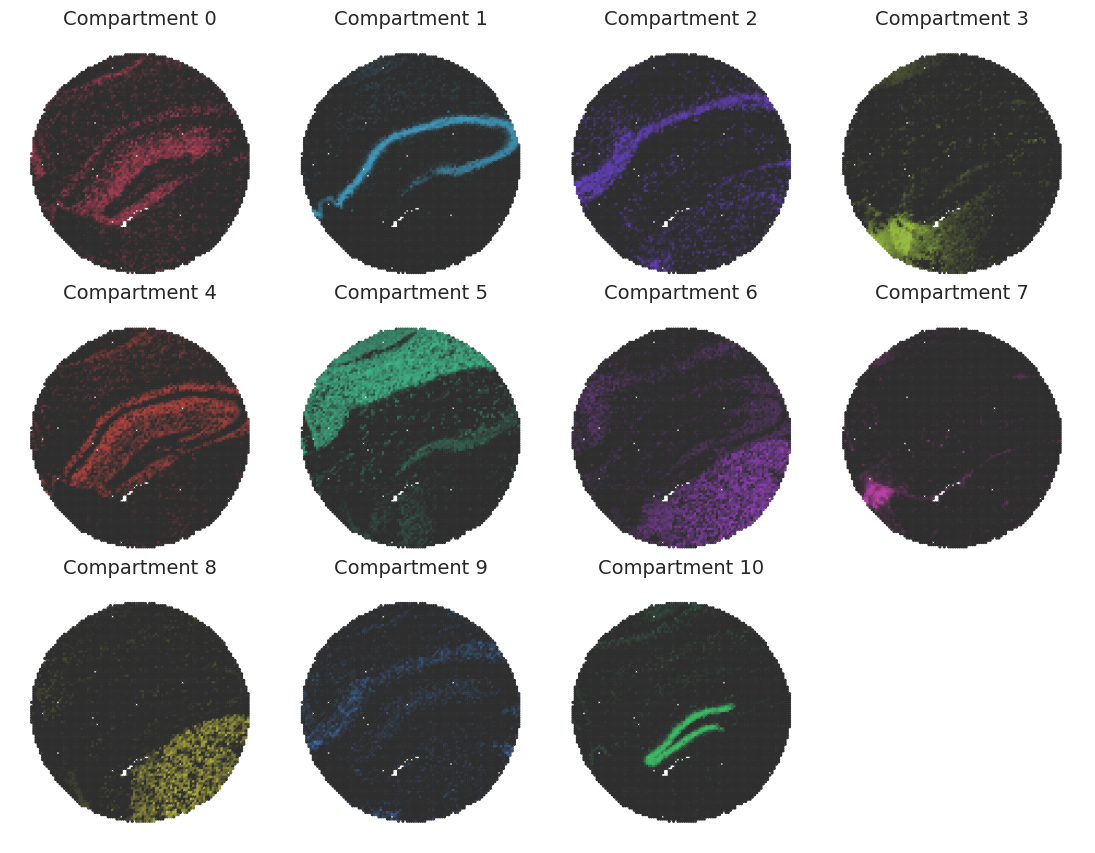

In [15]:
ch.plot_compartments(binned_adata, ncols=4, title_size=14, rasterized=True, seed=4)
plt.show()

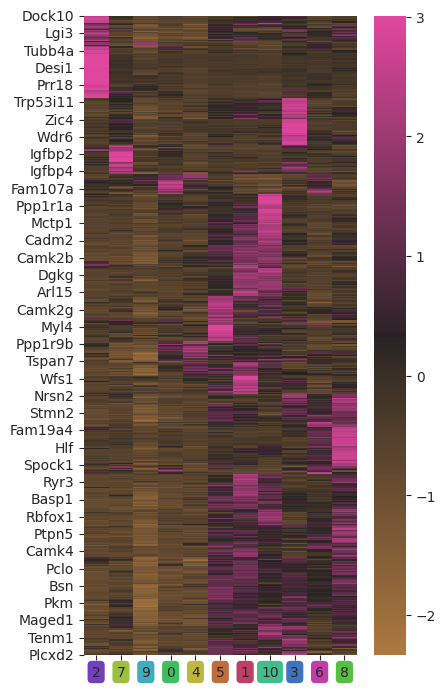

In [17]:
ch.plot_heatmap(binned_adata, reorder_comps=True, figsize=(4.5, 7), rasterized=True)
plt.show()

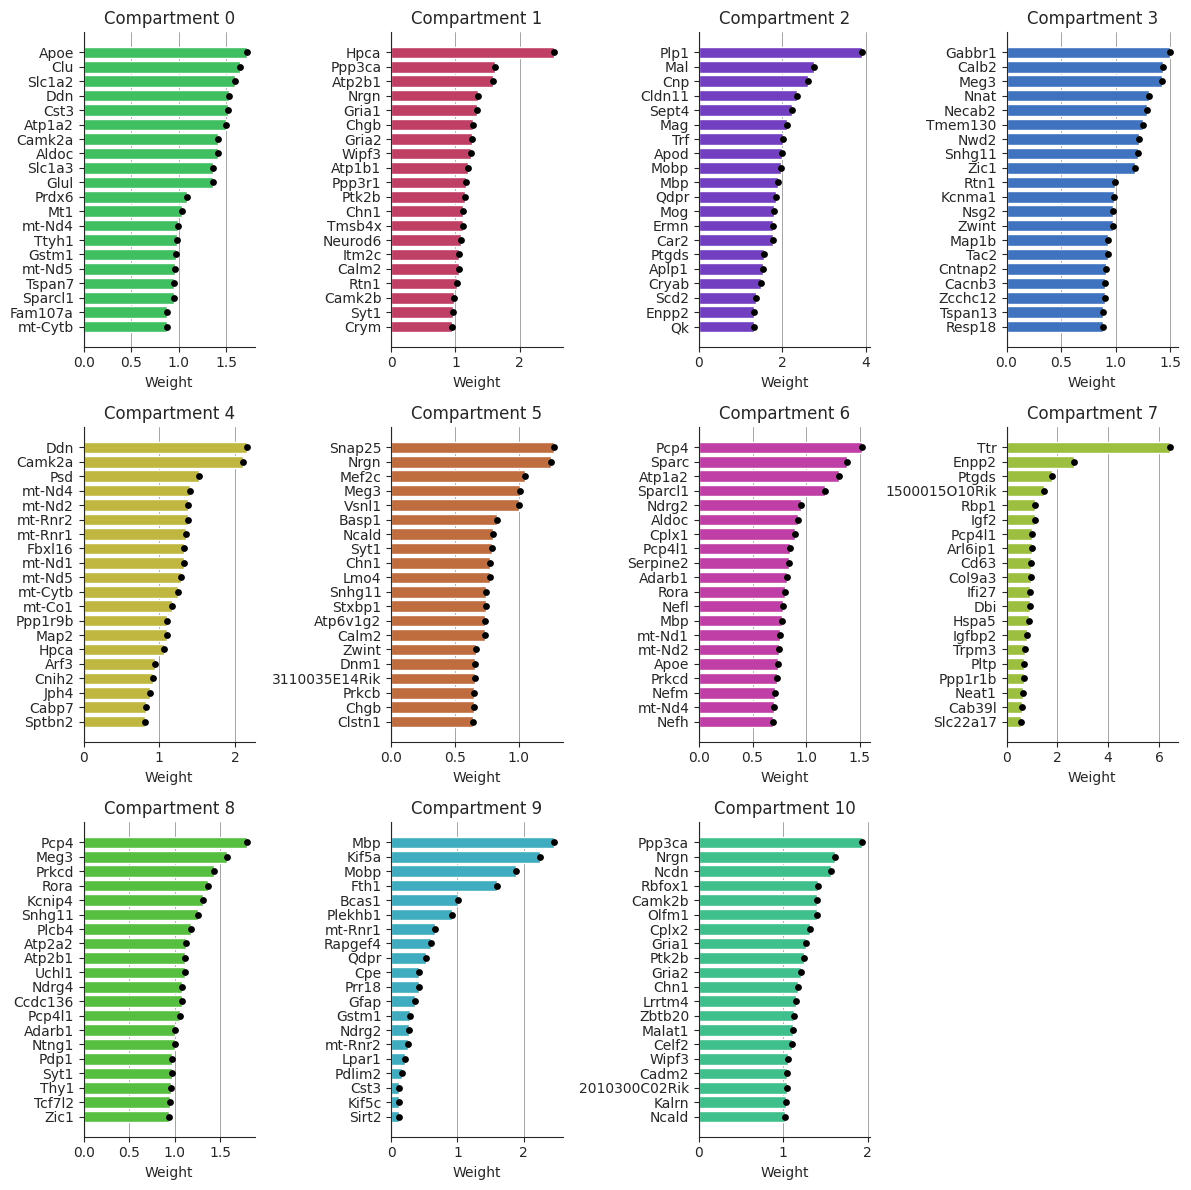

In [18]:
ch.plot_weights(binned_adata, ncols=4, seed=4)
plt.show()